# Transfer Learning

### Achievement

## 1. Introduction

In this notebook, we will explore the capabilities of transfer learning to create a binary classifier, able to detect malicious network traffic.    

As observed in a previous [experiment](https://github.com/cstub/ml-ids/blob/master/notebooks/03_ml-prototype/ml-prototype.ipynb), models trained on the [CIC-IDS-2018 dataset](https://www.unb.ca/cic/datasets/ids-2018.html) do not generalize well to data taken from different network environments because of the statistical differences in the distributions of the predictor variables. Consequently, given data from a new network environment, we are forced to retrain a new model using this data instead of applying the data to the existing model. If we have enough data of the new environment at our disposal this does not pose a particular problem. 
Acquiring a large amount of labeled data usually requires a high amount of effort though, so we may find ourselves in situations where we do not have enough data to train a model reaching a performance level that satisfies our requirements.    

In order to train a model achieving good performance using only a small amount of labeled data, we can facilitate the methods of unsupervised pretraining or transfer learning.    
Using unsupervised pretraining we train a model to learn an efficient representation of the source data using a large amount of unlabeled data (which is usually easier to collect) and use the learned representation layer as input to our model trained on the target data.    
Facilitating transfer learning, we reuse a model trained on a similar source task. For further reference, the different methods of transfer learning are explained in the following excellent [blog post](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a).     
In this notebook we will use the method of inductive transfer learning. This method is predominantly used in Computer Vision but can also be used in other scenarios. The concept, in regards to neural networks, revolves around the idea of reusing the lower layers and learned weights of a model trained on a similar source task, as illustrated in figure 1.     

<img src="img/transfer_learning.png" alt="Transfer learning using a deep neural network" style="width: 600px;"/>
<center>Figure 1: Transfer learning using a deep neural network (<a href="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch11.html#deep_chapter">Source</a>)</center>

This model is used as a starting point, where the output layers are removed and replaced with custom trainable layers. Training is then conducted in two steps, the second step being optional depending on the amount of data:
1. In the first step the weights of the pretrained layers are frozen and the model is trained using a normal learning rate. In this step the weights of the custom layers are trained.
2. In the second step the weights of pre-trained layers are unfrozen and training is performed with a lower learning rate in order to fine-tune the pre-trained weights but not destroy them by using a learning rate too large.

With this approach we strive to train a model, achieving reasonable performance, using only a fraction of the data usually required to train a machine learning model.

To perform our experiment, we use a subset of the [CIC-IDS-2017 dataset](https://www.unb.ca/cic/datasets/ids-2017.html) and perform the following steps:
1. Train a neural network only using the data from the [CIC-IDS-2017 dataset](https://www.unb.ca/cic/datasets/ids-2017.html).
2. Use unsupervised pretraining on a large amount of benign data and utilize the created coding layer as the input for a neural network trained on the dataset.
3. Facilitate transfer learning by using a deep neural network trained on the [CIC-IDS-2018 dataset](https://www.unb.ca/cic/datasets/ids-2018.html) as the starting point of our model, train the model on the [CIC-IDS-2017 dataset](https://www.unb.ca/cic/datasets/ids-2017.html) and fine-tune the model in a second training run.

Concluding the notebook, we compare the performance of the different approaches and take an unbiased performance measure by using the best model to infer the samples of the test dataset.

## 2. Dataset Preparation

In this section we load the dataset and prepare the data for training. The preprocessed dataset from CIC-IDS-2017 can be found at [Google Drive](https://drive.google.com/open?id=1Q2J_pPB0K0PHjq0YO5BPwYQwrvoZgYqo).

In [1]:
dataset_base_path = r'/home/glados/Development/Projects/ids-2017/processed'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from ml_ids.data.dataset import load_dataset
from ml_ids.data.metadata import FEATURES_NO_VARIANCE
from ml_ids.transform.preprocessing import create_pipeline
from ml_ids.transform.sampling import upsample_minority_classes
from ml_ids.model_selection import split_x_y, cross_val_train
from ml_ids.visualization import plot_hist, print_binary_performance, plot_pr_curve
from ml_ids.keras.prediction import predict
from ml_ids.tf_utils import enable_gpu_memory_growth
from notebook_utils import split_train_test, print_performance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers, metrics, constraints
from itertools import chain


K = keras.backend

rand_state = 42
tf.random.set_seed(rand_state)
np.random.seed(rand_state)

enable_gpu_memory_growth()

%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### 2.1 Data Loading & Preparation

In this part we load the dataset, specifing the features to omit. These encompass all features having no variance and features which should not be taken into account, in order to obtain a better generalization of the model.

Afterwards the dataset is splitted into:
* training set,
* test set.

To simulate a restricted amount of data, we downsample the training set to  `500` samples per attack category and  `7000` samples of benign traffic. This leaves us with a balanced training dataset containg `14000` samples.
The test set is preserved in order to have enough data to reliably measure the performance of the final estimator. 


We use median imputation as the strategy to impute missing values, as the distributions of all features, for which imputation is necessary, are highly skewed. Futhermore, we scale the data using a StandardScaler, as the neural network demands the data to be scaled, and upsample the malicious network traffic to obtain 500 samples per attack category. We perform upsampling by using the technique of Synthetic Minority Over-sampling provided by the [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) library.    
The `cols_to_impute` are taken from the preprocessor used to pepare the data for the CIC-IDS-2018 model in order to ensure the same ordering of the input features.

In [3]:
dataset = load_dataset(dataset_base_path,
                       omit_cols=FEATURES_NO_VARIANCE + ['timestamp', 'dst_port', 'protocol'],
                       preserve_neg_value_cols=['init_fwd_win_byts', 'init_bwd_win_byts'])

In [4]:
cols_to_impute = ['flow_duration', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot', 'fwd_iat_mean', 'fwd_iat_max', 'fwd_iat_min']

train_data, test_data, train_data_benign = split_train_test(dataset, 
                                                            nr_samples_per_attack=500, 
                                                            nr_samples_benign=7000,
                                                            test_size=0.5, 
                                                            random_state=rand_state)

X_train_raw, y_train = split_x_y(train_data)
X_train_benign_raw, y_train_benign = split_x_y(train_data_benign)
X_test_raw, y_test = split_x_y(test_data)

pipeline, get_col_names = create_pipeline(X_train_raw, 
                                          imputer_strategy='median',
                                          imputer_cols=cols_to_impute,
                                          scaler=StandardScaler)

pipeline.fit(pd.concat([X_train_raw, X_train_benign_raw]))
X_train = pipeline.transform(X_train_raw)
X_train_benign = pipeline.transform(X_train_benign_raw)
X_test = pipeline.transform(X_test_raw)

column_names = get_col_names()

print('\nTraining labels:')
print('================')
print(y_train.label.value_counts())
print('\nTest labels:')
print('============')
print(y_test.label.value_counts())

X_train, y_train = upsample_minority_classes(X_train, y_train, min_samples=500, random_state=rand_state)

print('\nSamples:')
print('========')
print('Training:        {}'.format(X_train.shape))
print('Training Benign: {}'.format(X_train_benign.shape))
print('Test:            {}'.format(X_test.shape))

print('\nMissing values:')
print('===============')
print('Training:        {}'.format(np.count_nonzero(np.isnan(X_train))))
print('Training Benign: {}'.format(np.count_nonzero(np.isnan(X_train_benign))))
print('Test:            {}'.format(np.count_nonzero(np.isnan(X_test))))

print('\nScaling:')
print('========')
print('Training:        min={}, max={}'.format(np.min(X_train), np.max(X_train)))
print('Training Benign: min={}, max={}'.format(np.min(X_train_benign), np.max(X_train_benign)))
print('Test:            min={}, max={}'.format(np.min(X_test), np.max(X_test)))


Training labels:
Benign                      7000
PortScan                     500
SSH-Bruteforce               500
DoS attacks-Slowloris        500
DDOS LOIT                    500
Bot                          500
DoS attacks-SlowHTTPTest     500
DoS attacks-GoldenEye        500
FTP-BruteForce               500
DoS attacks-Hulk             500
Brute Force -Web             500
Brute Force -XSS             326
Infilteration                 18
SQL Injection                 11
Heartbleed                     6
Name: label, dtype: int64

Test labels:
Benign                      1136549
DoS attacks-Hulk             115537
PortScan                      79465
DDOS LOIT                     64014
DoS attacks-GoldenEye          5147
FTP-BruteForce                 3969
SSH-Bruteforce                 2949
DoS attacks-Slowloris          2898
DoS attacks-SlowHTTPTest       2749
Bot                             983
Brute Force -Web                753
Brute Force -XSS                326
Infilteration  

### 2.2 Target Labels

As the upsampling process leaves us with an array of categorical target variables (benign and attack categories) we add a binary column indicating if the target label describes benign or malicious network traffic.    
The categorical column will be used to calculate the misclassification rate per category whereas the binary column will be used as target variable for model training.

In [5]:
y_train_is_attack = (y_train != 0).astype('int')
y_train = np.array([y_train, y_train_is_attack]).transpose()

## Training without Transfer Learning

### Training

In [6]:
def fit_plain_model(X_train, y_train, X_val, y_val, fit_args, first_run):
    input_dims = X_train.shape[1]
    
    activation = 'elu'
    initializer = 'he_normal'
    
    model = models.Sequential([
        layers.Dense(300, activation=activation, kernel_initializer=initializer, input_shape=[input_dims]),
        layers.Dense(300, activation=activation, kernel_initializer=initializer),
        layers.Dense(300, activation=activation, kernel_initializer=initializer),
        layers.Dense(300, activation=activation, kernel_initializer=initializer),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizers.Adam(lr=0.001), loss='binary_crossentropy')
    
    if first_run:
        print(model.summary())
    
    early_stopping = callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.0001)
    
    hist = model.fit(x=X_train, 
                     y=y_train, 
                     validation_data=(X_val, y_val),                
                     callbacks=[
                         early_stopping,
                         reduce_lr
                     ], **fit_args)
    
    return model, hist

In [7]:
cv_pred_plain, cv_y_true_plain, hists_plain = cross_val_train(fit_plain_model, 
                                                              X_train, 
                                                              y_train, 
                                                              target_stratify_fn=lambda y: y[:, 0],
                                                              target_transform_fn=lambda y: y[:, 1],
                                                              n_splits=5, 
                                                              fit_args={
                                                                  'epochs': 100,
                                                                  'batch_size': 16,
                                                              },
                                                              random_state=rand_state)


Fold 1/5:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               20700     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
Total params: 291,901
Trainable params: 291,901
Non-trainable params: 0
_______________________________________

Epoch 12/100
11200/11200 [==============================] - 2s 152us/sample - loss: 0.1346 - val_loss: 0.1443
Epoch 13/100
11200/11200 [==============================] - 2s 153us/sample - loss: 0.1322 - val_loss: 0.1757
Epoch 14/100
11200/11200 [==============================] - 2s 155us/sample - loss: 0.1265 - val_loss: 0.1557
Epoch 15/100
11200/11200 [==============================] - 2s 156us/sample - loss: 0.1317 - val_loss: 0.1452
Epoch 16/100
11200/11200 [==============================] - 2s 154us/sample - loss: 0.1199 - val_loss: 0.1289
Epoch 17/100
11200/11200 [==============================] - 2s 154us/sample - loss: 0.1284 - val_loss: 0.1420
Epoch 18/100
11200/11200 [==============================] - 2s 155us/sample - loss: 0.1226 - val_loss: 0.1452
Epoch 19/100
11200/11200 [==============================] - 2s 154us/sample - loss: 0.1262 - val_loss: 0.2128
Epoch 20/100
11200/11200 [==============================] - 2s 153us/sample - loss: 0.1275 - val_loss: 0.1421
Epoch 21/1

Epoch 39/100
11200/11200 [==============================] - 2s 158us/sample - loss: 0.0837 - val_loss: 0.1130
Epoch 40/100
11200/11200 [==============================] - 2s 157us/sample - loss: 0.0844 - val_loss: 0.1107
Epoch 41/100
11200/11200 [==============================] - 2s 155us/sample - loss: 0.0839 - val_loss: 0.1098
Epoch 42/100
11200/11200 [==============================] - 2s 157us/sample - loss: 0.0839 - val_loss: 0.1098
Epoch 43/100
11200/11200 [==============================] - 2s 157us/sample - loss: 0.0842 - val_loss: 0.1084
Epoch 44/100
11200/11200 [==============================] - 2s 157us/sample - loss: 0.0829 - val_loss: 0.1105
Epoch 45/100
11200/11200 [==============================] - 2s 157us/sample - loss: 0.0831 - val_loss: 0.1147
Epoch 46/100
11200/11200 [==============================] - 2s 157us/sample - loss: 0.0834 - val_loss: 0.1108
Epoch 47/100
11200/11200 [==============================] - 2s 157us/sample - loss: 0.0826 - val_loss: 0.1126
Epoch 48/1

11200/11200 [==============================] - 2s 155us/sample - loss: 0.1475 - val_loss: 0.1602
Epoch 13/100
11200/11200 [==============================] - 2s 156us/sample - loss: 0.1335 - val_loss: 0.1725
Epoch 14/100
11200/11200 [==============================] - 2s 156us/sample - loss: 0.1394 - val_loss: 0.1846
Epoch 15/100
11200/11200 [==============================] - 2s 155us/sample - loss: 0.1472 - val_loss: 0.1551
Epoch 16/100
11200/11200 [==============================] - 2s 156us/sample - loss: 0.1263 - val_loss: 0.1642
Epoch 17/100
11200/11200 [==============================] - 2s 155us/sample - loss: 0.1299 - val_loss: 0.1538
Epoch 18/100
11200/11200 [==============================] - 2s 154us/sample - loss: 0.1260 - val_loss: 0.1516
Epoch 19/100
11200/11200 [==============================] - 2s 154us/sample - loss: 0.1250 - val_loss: 0.1588
Epoch 20/100
11200/11200 [==============================] - 2s 156us/sample - loss: 0.1247 - val_loss: 0.1446
Epoch 21/100
11200/1120

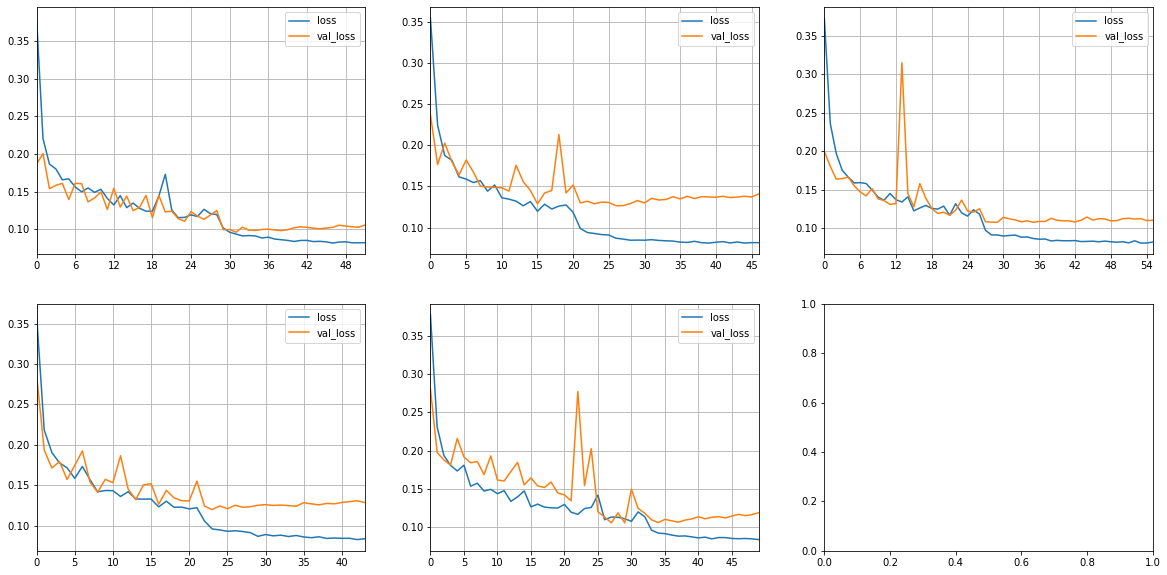

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for hist, ax in zip(hists_plain, chain.from_iterable(axes)):
    plot_hist(hist, ax=ax)

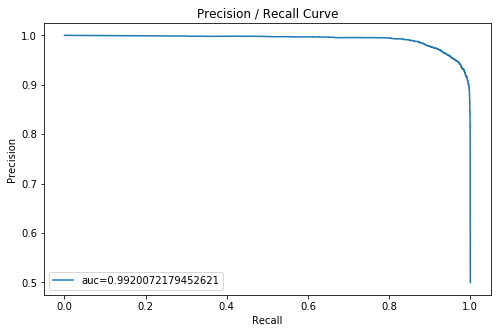

Average PR Score 0.9920072179452621

Classification Report:
              precision    recall  f1-score   support

           0      0.973     0.940     0.956      7000
           1      0.942     0.974     0.958      7000

    accuracy                          0.957     14000
   macro avg      0.957     0.957     0.957     14000
weighted avg      0.957     0.957     0.957     14000

Confusion Matrix:


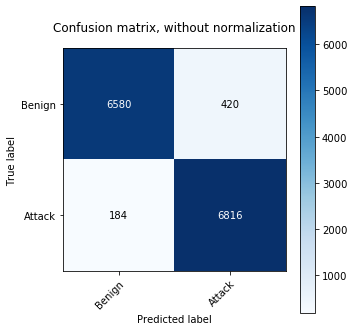

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Bot,64,500,0.128
DoS attacks-Hulk,56,500,0.112
Benign,420,7000,0.060
PortScan,21,500,0.042
Brute Force -XSS,14,500,0.028
SSH-Bruteforce,9,500,0.018
Brute Force -Web,9,500,0.018
DDOS LOIT,6,500,0.012
DoS attacks-Slowloris,3,500,0.006
DoS attacks-SlowHTTPTest,1,500,0.002


In [9]:
print_performance(cv_y_true_plain, cv_pred_plain)

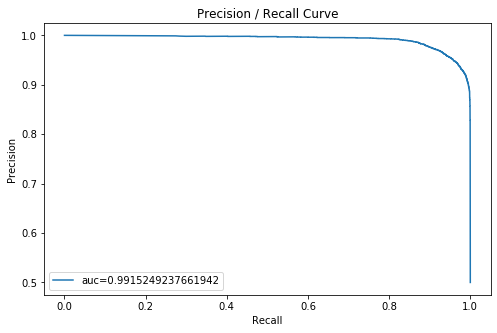

Average PR Score 0.9915249237661942

Classification Report:
              precision    recall  f1-score   support

           0      0.975     0.931     0.953      7000
           1      0.934     0.976     0.955      7000

    accuracy                          0.954     14000
   macro avg      0.954     0.954     0.954     14000
weighted avg      0.954     0.954     0.954     14000

Confusion Matrix:


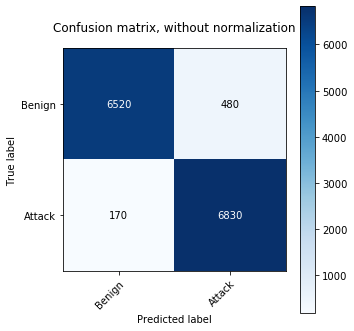

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Bot,69,500,0.138000
Benign,480,7000,0.068571
DoS attacks-Hulk,30,500,0.060000
PortScan,25,500,0.050000
Brute Force -XSS,11,500,0.022000
SSH-Bruteforce,11,500,0.022000
Brute Force -Web,10,500,0.020000
DDOS LOIT,6,500,0.012000
DoS attacks-Slowloris,3,500,0.006000
DoS attacks-SlowHTTPTest,2,500,0.004000


In [10]:
print_performance(cv_y_true_plain, cv_pred_plain)

## Unsupervised Pretraining

In [10]:
def train_stacked_autoencoder(X_train, epochs, batch_size, input_dims):
    activation = 'elu'
    dropout= 0.1

    stacked_ae = models.Sequential([
        layers.Dense(50, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0), input_shape=(input_dims,)),
        layers.Dense(30, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0)),
        layers.Dense(20, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0)),
        layers.Dense(10, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0), name='codings'),
        layers.Dense(20, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(30, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(50, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(input_dims)
    ])

    stacked_ae.compile(optimizer='adam', loss='huber_loss')

    early_stopping = callbacks.EarlyStopping(patience=15, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=3, min_lr=0.0001)
    mc = callbacks.ModelCheckpoint(filepath='models/stacked_autoencoder_model.h5', save_best_only=True, verbose=0)

    hist = stacked_ae.fit(x=X_train, 
                          y=X_train, 
                          validation_split=0.1,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=[early_stopping, reduce_lr, mc])
    
    return stacked_ae, hist

In [11]:
train_stacked_autoencoder(X_train_benign, epochs=50, batch_size=4096, input_dims=X_train.shape[1])

Train on 1016593 samples, validate on 112955 samples
Epoch 1/50
1016593/1016593 [==============================] - 2s 2us/sample - loss: 0.0918 - val_loss: 0.0480
Epoch 2/50
1016593/1016593 [==============================] - 1s 1us/sample - loss: 0.0566 - val_loss: 0.0381
Epoch 3/50
1016593/1016593 [==============================] - 1s 1us/sample - loss: 0.0504 - val_loss: 0.0348
Epoch 4/50
1016593/1016593 [==============================] - 1s 1us/sample - loss: 0.0473 - val_loss: 0.0318
Epoch 5/50
1016593/1016593 [==============================] - 1s 1us/sample - loss: 0.0448 - val_loss: 0.0304
Epoch 6/50
1016593/1016593 [==============================] - 1s 1us/sample - loss: 0.0429 - val_loss: 0.0285
Epoch 7/50
1016593/1016593 [==============================] - 1s 1us/sample - loss: 0.0416 - val_loss: 0.0274
Epoch 8/50
1016593/1016593 [==============================] - 1s 1us/sample - loss: 0.0404 - val_loss: 0.0270
Epoch 9/50
1016593/1016593 [==============================] - 1s 1u

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7facf0410630>,
 <tensorflow.python.keras.callbacks.History at 0x7facf01f1780>)

In [12]:
def fit_unsupervised_pretrain_model(X_train, y_train, X_val, y_val, fit_args, first_run):
    autoencoder = models.load_model('models/stacked_autoencoder_model.h5')
    
    for l in autoencoder.layers:
        l.trainable = False
        
    encoding_layers = []
    for l in autoencoder.layers:
        encoding_layers.append(l)
        if l.name == 'codings':
            break

    activation = 'elu'
    initializer = 'he_normal'
    
    model = models.Sequential(encoding_layers)
    model.add(layers.Dense(300, activation=activation, kernel_initializer=initializer, name='dense_train_1'))
    model.add(layers.Dense(300, activation=activation, kernel_initializer=initializer, name='dense_train_2'))
    model.add(layers.Dense(300, activation=activation, kernel_initializer=initializer, name='dense_train_3'))
    model.add(layers.Dense(300, activation=activation, kernel_initializer=initializer, name='dense_train_4'))
    model.add(layers.Dense(300, activation=activation, kernel_initializer=initializer, name='dense_train_5'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

    if first_run:
        print(model.summary())
    
    early_stopping = callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.0001)
    
    hist = model.fit(x=X_train, 
                     y=y_train, 
                     validation_data=(X_val, y_val),
                     callbacks=[
                         early_stopping,
                         reduce_lr
                     ], **fit_args)
    
    for l in model.layers:
        l.trainable = True
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy')
    
    reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)
    
    hist_ft = model.fit(x=X_train, 
                        y=y_train, 
                        validation_data=(X_val, y_val),
                        callbacks=[
                            early_stopping,
                            reduce_lr
                        ], **fit_args)
    
    return model, [hist, hist_ft]

In [13]:
cv_pred_pretrain, cv_y_true_pretrain, hists_pretrain = cross_val_train(fit_unsupervised_pretrain_model, 
                                                                       X_train, 
                                                                       y_train, 
                                                                       target_stratify_fn=lambda y: y[:, 0],
                                                                       target_transform_fn=lambda y: y[:, 1],
                                                                       n_splits=5, 
                                                                       fit_args={
                                                                          'epochs': 100,
                                                                          'batch_size': 16,
                                                                       },
                                                                       random_state=rand_state)


Fold 1/5:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                3450      
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_7 (Dense)              (None, 20)                620       
_________________________________________________________________
codings (Dense)              (None, 10)                210       
_________________________________________________________________
dense_train_1 (Dense)        (None, 300)               3300      
_________________________________________________________________
dense_train_2 (Dense)        (None, 300)               90300     
_________________________________________________________________
dense_train_3 (Dense)        (None, 300)     

Epoch 6/100
11200/11200 [==============================] - 3s 232us/sample - loss: 0.1203 - val_loss: 0.1408
Epoch 7/100
11200/11200 [==============================] - 3s 232us/sample - loss: 0.1198 - val_loss: 0.1501
Epoch 8/100
11200/11200 [==============================] - 3s 233us/sample - loss: 0.1189 - val_loss: 0.1350
Epoch 9/100
11200/11200 [==============================] - 3s 236us/sample - loss: 0.1169 - val_loss: 0.1330
Epoch 10/100
11200/11200 [==============================] - 3s 233us/sample - loss: 0.1125 - val_loss: 0.1305
Epoch 11/100
11200/11200 [==============================] - 3s 236us/sample - loss: 0.1155 - val_loss: 0.1289
Epoch 12/100
11200/11200 [==============================] - 3s 233us/sample - loss: 0.1126 - val_loss: 0.1312
Epoch 13/100
11200/11200 [==============================] - 3s 233us/sample - loss: 0.1151 - val_loss: 0.1284
Epoch 14/100
11200/11200 [==============================] - 3s 239us/sample - loss: 0.1104 - val_loss: 0.1338
Epoch 15/100
1

Epoch 30/100
11200/11200 [==============================] - 2s 176us/sample - loss: 0.1002 - val_loss: 0.1403
Epoch 31/100
11200/11200 [==============================] - 2s 179us/sample - loss: 0.1011 - val_loss: 0.1369
Epoch 32/100
11200/11200 [==============================] - 2s 178us/sample - loss: 0.1005 - val_loss: 0.1388
Epoch 33/100
11200/11200 [==============================] - 2s 174us/sample - loss: 0.0980 - val_loss: 0.1462
Epoch 34/100
11200/11200 [==============================] - 2s 179us/sample - loss: 0.0975 - val_loss: 0.1355
Epoch 35/100
11200/11200 [==============================] - 2s 180us/sample - loss: 0.0989 - val_loss: 0.1372
Epoch 36/100
11200/11200 [==============================] - 2s 179us/sample - loss: 0.0982 - val_loss: 0.1439
Epoch 37/100
11200/11200 [==============================] - 2s 179us/sample - loss: 0.0978 - val_loss: 0.1401
Epoch 38/100
11200/11200 [==============================] - 2s 179us/sample - loss: 0.0961 - val_loss: 0.1383
Epoch 39/1

11200/11200 [==============================] - 2s 181us/sample - loss: 0.1744 - val_loss: 0.1544
Epoch 9/100
11200/11200 [==============================] - 2s 177us/sample - loss: 0.1789 - val_loss: 0.1739
Epoch 10/100
11200/11200 [==============================] - 2s 182us/sample - loss: 0.1740 - val_loss: 0.1720
Epoch 11/100
11200/11200 [==============================] - 2s 179us/sample - loss: 0.1734 - val_loss: 0.1507
Epoch 12/100
11200/11200 [==============================] - 2s 181us/sample - loss: 0.1616 - val_loss: 0.1507
Epoch 13/100
11200/11200 [==============================] - 2s 182us/sample - loss: 0.1663 - val_loss: 0.1545
Epoch 14/100
11200/11200 [==============================] - 2s 179us/sample - loss: 0.1680 - val_loss: 0.1593
Epoch 15/100
11200/11200 [==============================] - 2s 179us/sample - loss: 0.1610 - val_loss: 0.1767
Epoch 16/100
11200/11200 [==============================] - 2s 179us/sample - loss: 0.1617 - val_loss: 0.1902
Epoch 17/100
11200/11200

11200/11200 [==============================] - 3s 237us/sample - loss: 0.0867 - val_loss: 0.1158
Epoch 44/100
11200/11200 [==============================] - 3s 237us/sample - loss: 0.0870 - val_loss: 0.1141
Epoch 45/100
11200/11200 [==============================] - 3s 229us/sample - loss: 0.0871 - val_loss: 0.1156
Epoch 46/100
11200/11200 [==============================] - 3s 238us/sample - loss: 0.0874 - val_loss: 0.1168

Fold 4/5:
Train on 11200 samples, validate on 2800 samples
Epoch 1/100
11200/11200 [==============================] - 2s 223us/sample - loss: 0.4816 - val_loss: 0.2745
Epoch 2/100
11200/11200 [==============================] - 2s 182us/sample - loss: 0.2765 - val_loss: 0.2388
Epoch 3/100
11200/11200 [==============================] - 2s 180us/sample - loss: 0.2402 - val_loss: 0.1737
Epoch 4/100
11200/11200 [==============================] - 2s 185us/sample - loss: 0.2090 - val_loss: 0.1953
Epoch 5/100
11200/11200 [==============================] - 2s 182us/sample - 

11200/11200 [==============================] - 3s 232us/sample - loss: 0.0873 - val_loss: 0.1171
Epoch 22/100
11200/11200 [==============================] - 3s 234us/sample - loss: 0.0875 - val_loss: 0.1158
Epoch 23/100
11200/11200 [==============================] - 3s 235us/sample - loss: 0.0873 - val_loss: 0.1157
Epoch 24/100
11200/11200 [==============================] - 3s 235us/sample - loss: 0.0874 - val_loss: 0.1156
Epoch 25/100
11200/11200 [==============================] - 3s 234us/sample - loss: 0.0879 - val_loss: 0.1160
Epoch 26/100
11200/11200 [==============================] - 3s 237us/sample - loss: 0.0878 - val_loss: 0.1181
Epoch 27/100
11200/11200 [==============================] - 3s 236us/sample - loss: 0.0882 - val_loss: 0.1186
Epoch 28/100
11200/11200 [==============================] - 3s 234us/sample - loss: 0.0870 - val_loss: 0.1162
Epoch 29/100
11200/11200 [==============================] - 3s 238us/sample - loss: 0.0869 - val_loss: 0.1171
Epoch 30/100
11200/1120

11200/11200 [==============================] - 3s 236us/sample - loss: 0.1306 - val_loss: 0.1652
Epoch 5/100
11200/11200 [==============================] - 3s 230us/sample - loss: 0.1281 - val_loss: 0.1666
Epoch 6/100
11200/11200 [==============================] - 3s 236us/sample - loss: 0.1273 - val_loss: 0.1736
Epoch 7/100
11200/11200 [==============================] - 3s 234us/sample - loss: 0.1224 - val_loss: 0.1743
Epoch 8/100
11200/11200 [==============================] - 3s 236us/sample - loss: 0.1213 - val_loss: 0.1787
Epoch 9/100
11200/11200 [==============================] - 3s 237us/sample - loss: 0.1201 - val_loss: 0.1687
Epoch 10/100
11200/11200 [==============================] - 3s 238us/sample - loss: 0.1106 - val_loss: 0.1671
Epoch 11/100
11200/11200 [==============================] - 3s 237us/sample - loss: 0.1081 - val_loss: 0.1678
Epoch 12/100
11200/11200 [==============================] - 3s 230us/sample - loss: 0.1047 - val_loss: 0.1699
Epoch 13/100
11200/11200 [==

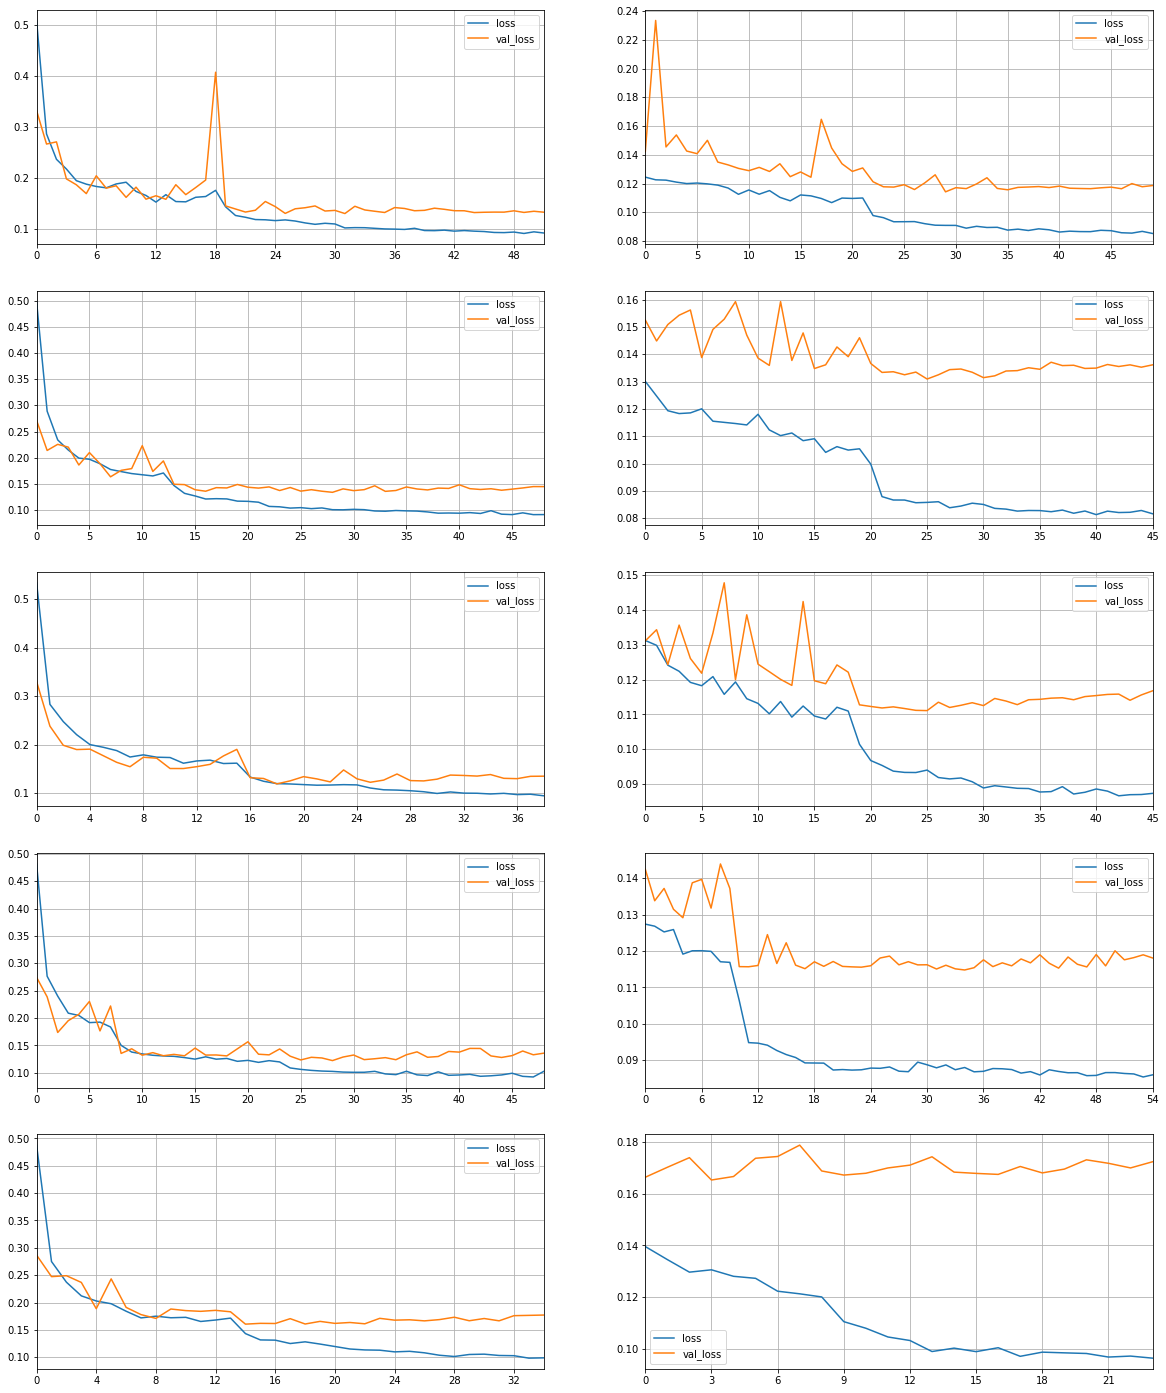

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
for hist, ax in zip(hists_pretrain, chain.from_iterable(axes)):
    plot_hist(hist, ax=ax)

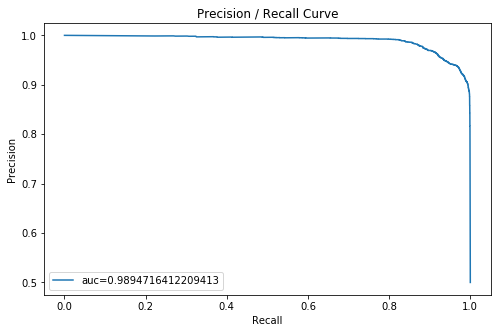

Average PR Score 0.9894716412209413

Classification Report:
              precision    recall  f1-score   support

           0      0.968     0.934     0.951      7000
           1      0.936     0.969     0.952      7000

    accuracy                          0.951     14000
   macro avg      0.952     0.952     0.951     14000
weighted avg      0.952     0.952     0.951     14000

Confusion Matrix:


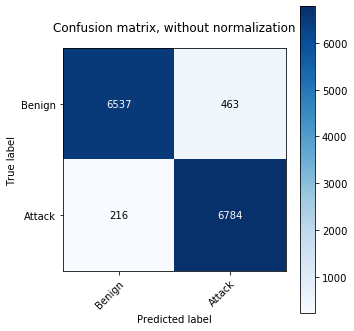

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Bot,94,500,0.188000
DoS attacks-Hulk,56,500,0.112000
Benign,463,7000,0.066143
Brute Force -Web,15,500,0.030000
Brute Force -XSS,13,500,0.026000
DDOS LOIT,10,500,0.020000
PortScan,8,500,0.016000
SSH-Bruteforce,7,500,0.014000
DoS attacks-SlowHTTPTest,4,500,0.008000
DoS attacks-GoldenEye,4,500,0.008000


In [15]:
print_performance(cv_y_true_pretrain, cv_pred_pretrain)

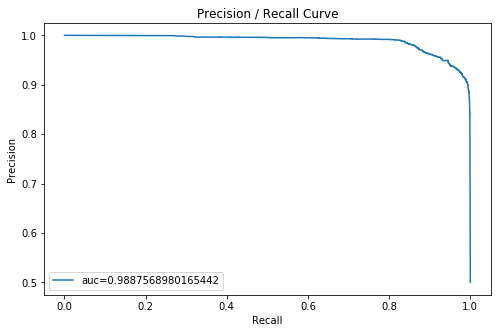

Average PR Score 0.9887568980165442

Classification Report:
              precision    recall  f1-score   support

           0      0.971     0.926     0.948      7000
           1      0.929     0.972     0.950      7000

    accuracy                          0.949     14000
   macro avg      0.950     0.949     0.949     14000
weighted avg      0.950     0.949     0.949     14000

Confusion Matrix:


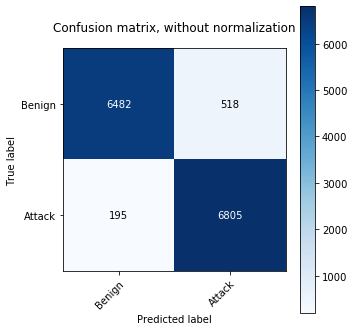

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Bot,80,500,0.160
DoS attacks-Hulk,57,500,0.114
Benign,518,7000,0.074
FTP-BruteForce,18,500,0.036
Brute Force -XSS,13,500,0.026
DDOS LOIT,7,500,0.014
SSH-Bruteforce,5,500,0.010
DoS attacks-GoldenEye,5,500,0.010
DoS attacks-SlowHTTPTest,4,500,0.008
DoS attacks-Slowloris,3,500,0.006


In [21]:
print_performance(cv_y_true_pretrain, cv_pred_pretrain)

## Transfer Learning

In [16]:
def fit_transfer_learning_model(X_train, y_train, X_val, y_val, fit_args, first_run):
    pretrained_model = models.load_model('models/dl_pretrained_model_ids_2018.h5')
    
    for l in pretrained_model.layers:
        l.trainable = False
        
    model = models.Sequential(pretrained_model.layers[:-2])
    model.add(layers.Dense(300, activation='elu', kernel_initializer='he_normal', name='dense_non_pretrained')) 
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid', name='output'))

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

    if first_run:
        print(model.summary())
    
    early_stopping = callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.0001)
    
    hist = model.fit(x=X_train, 
                     y=y_train, 
                     validation_data=(X_val, y_val),
                     callbacks=[
                         early_stopping,
                         reduce_lr
                     ], **fit_args)
    
    for l in model.layers[2:]:
        l.trainable = True
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy')
    
    reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)
    
    hist_ft = model.fit(x=X_train, 
                        y=y_train, 
                        validation_data=(X_val, y_val),
                        callbacks=[
                            early_stopping,
                            reduce_lr
                        ], **fit_args)
    
    return model, [hist, hist_ft]

In [17]:
cv_pred_tl, cv_y_true_tl, hists_tl = cross_val_train(fit_transfer_learning_model, 
                                                     X_train, 
                                                     y_train, 
                                                     target_stratify_fn=lambda y: y[:, 0],
                                                     target_transform_fn=lambda y: y[:, 1], 
                                                     n_splits=5, 
                                                     fit_args={
                                                         'epochs': 100,
                                                         'batch_size': 16,
                                                     },
                                                     random_state=rand_state)


Fold 1/5:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               20700     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_non_pretrained (Dense) (None, 300)               90300     
_________________________________________________________________
dropout (Dropout)            (None, 300)     

Epoch 62/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.0960 - val_loss: 0.1353
Epoch 63/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.0944 - val_loss: 0.1349
Epoch 64/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.0946 - val_loss: 0.1358
Epoch 65/100
11200/11200 [==============================] - 2s 142us/sample - loss: 0.0948 - val_loss: 0.1402
Epoch 66/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.0963 - val_loss: 0.1369
Epoch 67/100
11200/11200 [==============================] - 2s 139us/sample - loss: 0.0927 - val_loss: 0.1347
Epoch 68/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.0937 - val_loss: 0.1361
Epoch 69/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.0934 - val_loss: 0.1358
Epoch 70/100
11200/11200 [==============================] - 2s 139us/sample - loss: 0.0946 - val_loss: 0.1350
Epoch 71/1

11200/11200 [==============================] - 2s 140us/sample - loss: 0.1155 - val_loss: 0.1424
Epoch 23/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.1175 - val_loss: 0.1428
Epoch 24/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.1175 - val_loss: 0.1448
Epoch 25/100
11200/11200 [==============================] - 2s 142us/sample - loss: 0.1130 - val_loss: 0.1457
Epoch 26/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.1100 - val_loss: 0.1372
Epoch 27/100
11200/11200 [==============================] - 2s 139us/sample - loss: 0.1083 - val_loss: 0.1379
Epoch 28/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.1094 - val_loss: 0.1382
Epoch 29/100
11200/11200 [==============================] - 2s 142us/sample - loss: 0.1070 - val_loss: 0.1342
Epoch 30/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.1042 - val_loss: 0.1414
Epoch 31/100
11200/1120

11200/11200 [==============================] - 2s 141us/sample - loss: 0.0881 - val_loss: 0.1326
Epoch 97/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.0827 - val_loss: 0.1299
Epoch 98/100
11200/11200 [==============================] - 2s 139us/sample - loss: 0.0855 - val_loss: 0.1303
Epoch 99/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.0864 - val_loss: 0.1282
Epoch 100/100
11200/11200 [==============================] - 2s 143us/sample - loss: 0.0862 - val_loss: 0.1271
Train on 11200 samples, validate on 2800 samples
Epoch 1/100
11200/11200 [==============================] - 2s 195us/sample - loss: 0.1049 - val_loss: 0.1494
Epoch 2/100
11200/11200 [==============================] - 2s 163us/sample - loss: 0.0958 - val_loss: 0.1250
Epoch 3/100
11200/11200 [==============================] - 2s 160us/sample - loss: 0.0852 - val_loss: 0.1272
Epoch 4/100
11200/11200 [==============================] - 2s 162us/sample - loss: 0.0

11200/11200 [==============================] - 2s 140us/sample - loss: 0.1170 - val_loss: 0.1496
Epoch 23/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.1180 - val_loss: 0.1554
Epoch 24/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.1176 - val_loss: 0.1522
Epoch 25/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.1113 - val_loss: 0.1487
Epoch 26/100
11200/11200 [==============================] - 2s 143us/sample - loss: 0.1115 - val_loss: 0.1465
Epoch 27/100
11200/11200 [==============================] - 2s 139us/sample - loss: 0.1132 - val_loss: 0.1469
Epoch 28/100
11200/11200 [==============================] - 2s 143us/sample - loss: 0.1074 - val_loss: 0.1487
Epoch 29/100
11200/11200 [==============================] - 2s 139us/sample - loss: 0.1108 - val_loss: 0.1495
Epoch 30/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.1075 - val_loss: 0.1453
Epoch 31/100
11200/1120

11200/11200 [==============================] - 2s 142us/sample - loss: 0.0881 - val_loss: 0.1447
Epoch 97/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.0859 - val_loss: 0.1413
Epoch 98/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.0864 - val_loss: 0.1482
Epoch 99/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.0886 - val_loss: 0.1450
Epoch 100/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.0872 - val_loss: 0.1464
Train on 11200 samples, validate on 2800 samples
Epoch 1/100
11200/11200 [==============================] - 2s 197us/sample - loss: 0.1107 - val_loss: 0.1517
Epoch 2/100
11200/11200 [==============================] - 2s 163us/sample - loss: 0.0945 - val_loss: 0.1447
Epoch 3/100
11200/11200 [==============================] - 2s 162us/sample - loss: 0.0934 - val_loss: 0.1565
Epoch 4/100
11200/11200 [==============================] - 2s 162us/sample - loss: 0.0

11200/11200 [==============================] - 2s 140us/sample - loss: 0.1776 - val_loss: 0.1769
Epoch 14/100
11200/11200 [==============================] - 2s 139us/sample - loss: 0.1778 - val_loss: 0.1647
Epoch 15/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.1890 - val_loss: 0.2653
Epoch 16/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.1812 - val_loss: 0.1564
Epoch 17/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.1617 - val_loss: 0.1512
Epoch 18/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.1634 - val_loss: 0.1470
Epoch 19/100
11200/11200 [==============================] - 2s 139us/sample - loss: 0.1545 - val_loss: 0.1330
Epoch 20/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.1436 - val_loss: 0.1304
Epoch 21/100
11200/11200 [==============================] - 2s 142us/sample - loss: 0.1378 - val_loss: 0.1420
Epoch 22/100
11200/1120

11200/11200 [==============================] - 2s 138us/sample - loss: 0.0850 - val_loss: 0.1084
Epoch 88/100
11200/11200 [==============================] - 2s 139us/sample - loss: 0.0859 - val_loss: 0.1074
Epoch 89/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.0875 - val_loss: 0.1055
Epoch 90/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.0835 - val_loss: 0.1101
Epoch 91/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.0834 - val_loss: 0.1113
Epoch 92/100
11200/11200 [==============================] - 2s 142us/sample - loss: 0.0837 - val_loss: 0.1064
Epoch 93/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.0863 - val_loss: 0.1072
Epoch 94/100
11200/11200 [==============================] - 2s 140us/sample - loss: 0.0863 - val_loss: 0.1068
Epoch 95/100
11200/11200 [==============================] - 2s 142us/sample - loss: 0.0868 - val_loss: 0.1100
Epoch 96/100
11200/1120

11200/11200 [==============================] - 2s 161us/sample - loss: 0.0457 - val_loss: 0.0841
Epoch 62/100
11200/11200 [==============================] - 2s 161us/sample - loss: 0.0448 - val_loss: 0.0835
Epoch 63/100
11200/11200 [==============================] - 2s 159us/sample - loss: 0.0444 - val_loss: 0.0838
Epoch 64/100
11200/11200 [==============================] - 2s 163us/sample - loss: 0.0446 - val_loss: 0.0819
Epoch 65/100
11200/11200 [==============================] - 2s 163us/sample - loss: 0.0455 - val_loss: 0.0824
Epoch 66/100
11200/11200 [==============================] - 2s 161us/sample - loss: 0.0452 - val_loss: 0.0832
Epoch 67/100
11200/11200 [==============================] - 2s 161us/sample - loss: 0.0461 - val_loss: 0.0842
Epoch 68/100
11200/11200 [==============================] - 2s 162us/sample - loss: 0.0452 - val_loss: 0.0863
Epoch 69/100
11200/11200 [==============================] - 2s 163us/sample - loss: 0.0456 - val_loss: 0.0832
Epoch 70/100
11200/1120

11200/11200 [==============================] - 2s 140us/sample - loss: 0.1036 - val_loss: 0.1304
Epoch 45/100
11200/11200 [==============================] - 2s 139us/sample - loss: 0.1010 - val_loss: 0.1268
Epoch 46/100
11200/11200 [==============================] - 2s 139us/sample - loss: 0.0982 - val_loss: 0.1279
Epoch 47/100
11200/11200 [==============================] - 2s 138us/sample - loss: 0.1023 - val_loss: 0.1302
Epoch 48/100
11200/11200 [==============================] - 2s 143us/sample - loss: 0.1010 - val_loss: 0.1274
Epoch 49/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.0960 - val_loss: 0.1272
Epoch 50/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.0986 - val_loss: 0.1296
Epoch 51/100
11200/11200 [==============================] - 2s 142us/sample - loss: 0.0988 - val_loss: 0.1304
Epoch 52/100
11200/11200 [==============================] - 2s 141us/sample - loss: 0.0993 - val_loss: 0.1297
Epoch 53/100
11200/1120

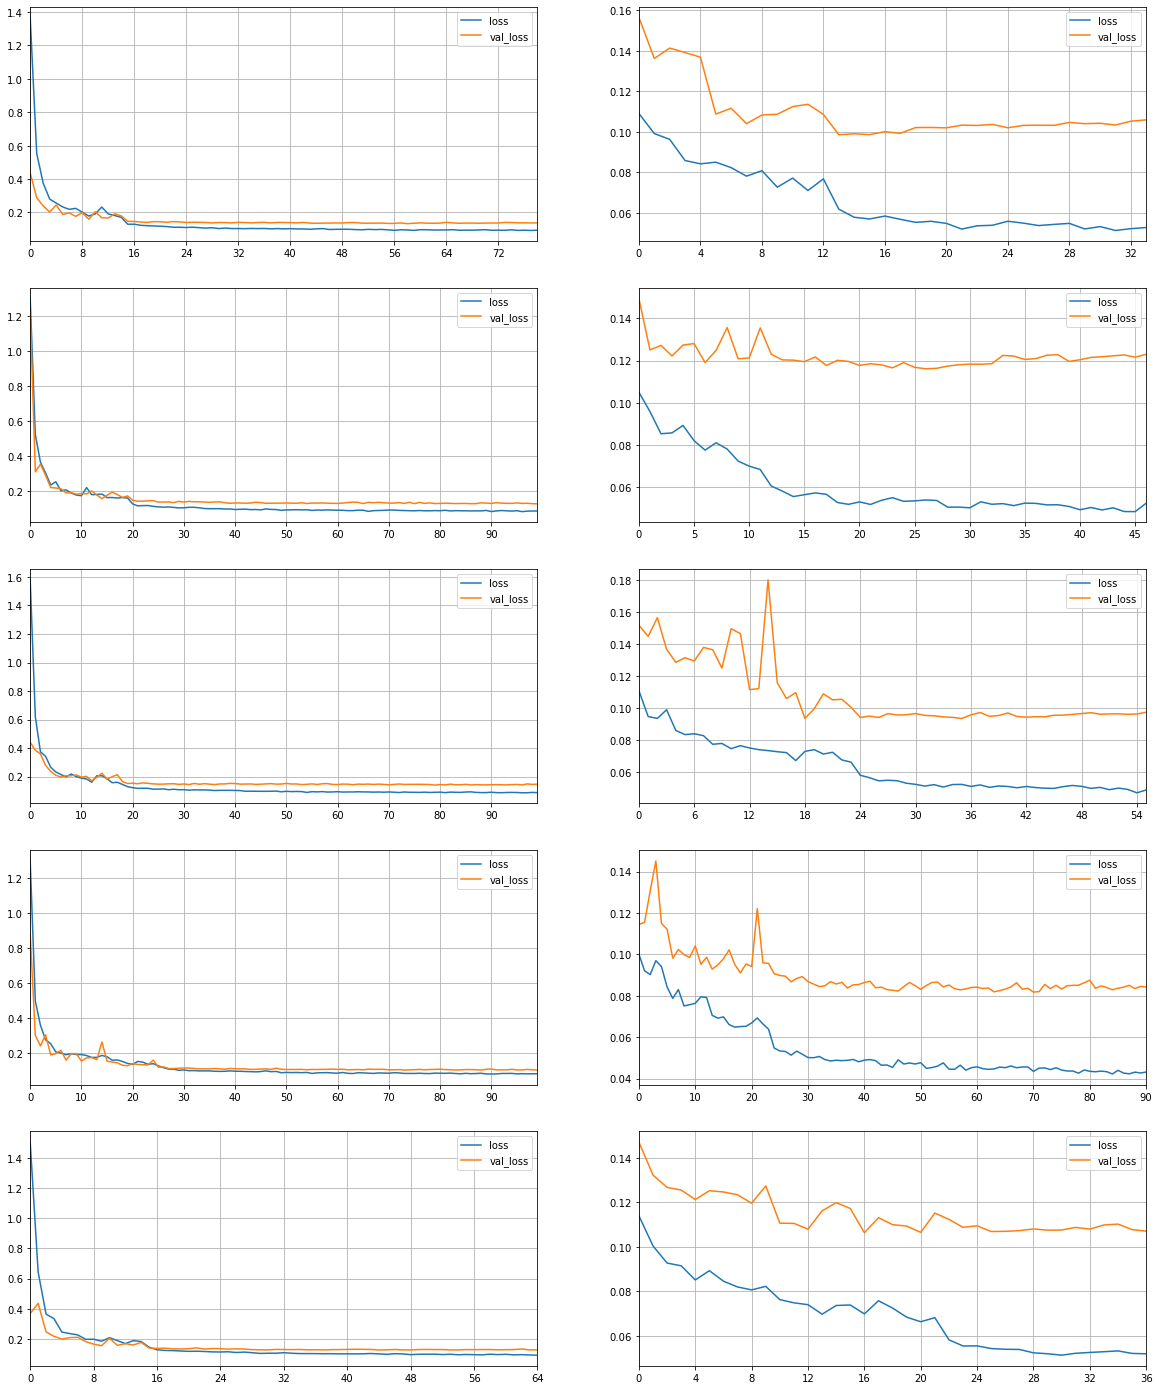

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
for hist, ax in zip(hists_tl, chain.from_iterable(axes)):
    plot_hist(hist, ax=ax)

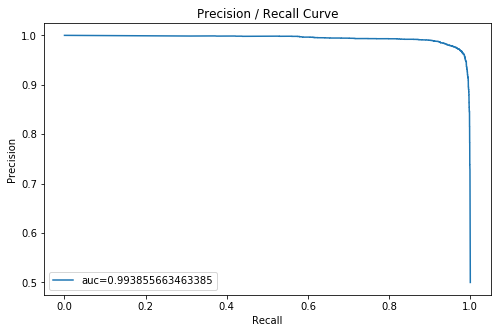

Average PR Score 0.993855663463385

Classification Report:
              precision    recall  f1-score   support

           0      0.982     0.962     0.972      7000
           1      0.962     0.983     0.972      7000

    accuracy                          0.972     14000
   macro avg      0.972     0.972     0.972     14000
weighted avg      0.972     0.972     0.972     14000

Confusion Matrix:


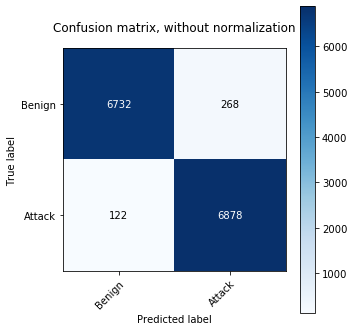

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Bot,31,500,0.062000
PortScan,23,500,0.046000
Benign,268,7000,0.038286
DoS attacks-Hulk,19,500,0.038000
SSH-Bruteforce,9,500,0.018000
Infilteration,8,500,0.016000
DDOS LOIT,7,500,0.014000
Brute Force -XSS,6,500,0.012000
DoS attacks-Slowloris,6,500,0.012000
FTP-BruteForce,4,500,0.008000


In [19]:
print_performance(cv_y_true_tl, cv_pred_tl)

## Evaluation on test set

In [28]:
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train,
                                                                          y_train,
                                                                          test_size=0.1,
                                                                          stratify=y_train[:, 0],
                                                                          random_state=rand_state)

best_model, hist = fit_transfer_learning_model(X_train_final, 
                                               y_train_final[:, 1], 
                                               X_val_final, 
                                               y_val_final[:, 1],                                
                                               fit_args={
                                                   'epochs': 100,
                                                   'batch_size': 16,
                                               },
                                               first_run=True)                                            

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               20700     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
Total params: 291,901
Trainable params: 291,901
Non-trainable params: 0
________________________________________________

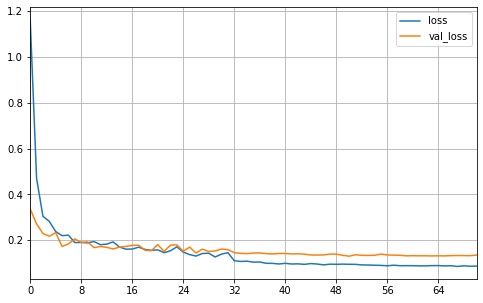

In [21]:
plot_hist(hist[0])

Classification Report:
              precision    recall  f1-score   support

           0      0.990     0.962     0.976   1136549
           1      0.861     0.962     0.909    278823

    accuracy                          0.962   1415372
   macro avg      0.926     0.962     0.942   1415372
weighted avg      0.965     0.962     0.963   1415372

Confusion Matrix:


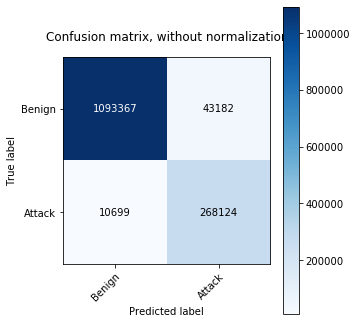

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,7,18,0.388889
Bot,60,983,0.061038
PortScan,3894,79465,0.049003
DoS attacks-Hulk,4910,115537,0.042497
Benign,43182,1136549,0.037994
DDOS LOIT,1664,64014,0.025994
Brute Force -XSS,5,326,0.015337
SSH-Bruteforce,42,2949,0.014242
DoS attacks-GoldenEye,67,5147,0.013017
DoS attacks-SlowHTTPTest,23,2749,0.008367


In [23]:
pred_test = predict(best_model, X_test)
print_binary_performance(y_test, y_test.label_is_attack.values, pred_test)

In [33]:
from catboost import CatBoostClassifier, Pool

train_pool = Pool(X_train_final, y_train_final[:, 1])
val_pool = Pool(X_val_final, y_val_final[:, 1])

clf_gb = CatBoostClassifier(loss_function='Logloss',                     
                            iterations=2000,
                            task_type='GPU',
                            verbose=1,
                            random_seed=rand_state)

clf_gb.fit(train_pool, eval_set=val_pool)

Learning rate set to 0.075674
0:	learn: 0.5918159	test: 0.5921172	best: 0.5921172 (0)	total: 29.1ms	remaining: 58.2s
1:	learn: 0.5165656	test: 0.5174722	best: 0.5174722 (1)	total: 57.4ms	remaining: 57.4s
2:	learn: 0.4614079	test: 0.4626948	best: 0.4626948 (2)	total: 85.7ms	remaining: 57.1s
3:	learn: 0.4142229	test: 0.4160948	best: 0.4160948 (3)	total: 114ms	remaining: 57.1s
4:	learn: 0.3710943	test: 0.3727672	best: 0.3727672 (4)	total: 143ms	remaining: 57.1s
5:	learn: 0.3418150	test: 0.3435377	best: 0.3435377 (5)	total: 168ms	remaining: 55.8s
6:	learn: 0.3085335	test: 0.3102721	best: 0.3102721 (6)	total: 192ms	remaining: 54.7s
7:	learn: 0.2854135	test: 0.2869307	best: 0.2869307 (7)	total: 217ms	remaining: 54s
8:	learn: 0.2655761	test: 0.2657410	best: 0.2657410 (8)	total: 241ms	remaining: 53.4s
9:	learn: 0.2449389	test: 0.2456593	best: 0.2456593 (9)	total: 266ms	remaining: 52.8s
10:	learn: 0.2255351	test: 0.2254418	best: 0.2254418 (10)	total: 290ms	remaining: 52.4s
11:	learn: 0.2083323	

97:	learn: 0.0329879	test: 0.0372405	best: 0.0372405 (97)	total: 2.63s	remaining: 51s
98:	learn: 0.0326203	test: 0.0371407	best: 0.0371407 (98)	total: 2.65s	remaining: 50.9s
99:	learn: 0.0321055	test: 0.0368747	best: 0.0368747 (99)	total: 2.68s	remaining: 50.9s
100:	learn: 0.0319274	test: 0.0367246	best: 0.0367246 (100)	total: 2.71s	remaining: 50.9s
101:	learn: 0.0316527	test: 0.0366656	best: 0.0366656 (101)	total: 2.73s	remaining: 50.9s
102:	learn: 0.0316454	test: 0.0366623	best: 0.0366623 (102)	total: 2.76s	remaining: 50.8s
103:	learn: 0.0313068	test: 0.0363869	best: 0.0363869 (103)	total: 2.79s	remaining: 50.8s
104:	learn: 0.0310809	test: 0.0362832	best: 0.0362832 (104)	total: 2.81s	remaining: 50.8s
105:	learn: 0.0309668	test: 0.0362467	best: 0.0362467 (105)	total: 2.84s	remaining: 50.8s
106:	learn: 0.0307420	test: 0.0360249	best: 0.0360249 (106)	total: 2.87s	remaining: 50.7s
107:	learn: 0.0302966	test: 0.0356133	best: 0.0356133 (107)	total: 2.9s	remaining: 50.7s
108:	learn: 0.02982

190:	learn: 0.0184154	test: 0.0251893	best: 0.0251810 (187)	total: 4.99s	remaining: 47.3s
191:	learn: 0.0183996	test: 0.0251305	best: 0.0251305 (191)	total: 5.02s	remaining: 47.2s
192:	learn: 0.0183239	test: 0.0250224	best: 0.0250224 (192)	total: 5.04s	remaining: 47.2s
193:	learn: 0.0183163	test: 0.0250258	best: 0.0250224 (192)	total: 5.07s	remaining: 47.2s
194:	learn: 0.0181864	test: 0.0248033	best: 0.0248033 (194)	total: 5.1s	remaining: 47.2s
195:	learn: 0.0181632	test: 0.0247889	best: 0.0247889 (195)	total: 5.12s	remaining: 47.2s
196:	learn: 0.0181562	test: 0.0248022	best: 0.0247889 (195)	total: 5.15s	remaining: 47.1s
197:	learn: 0.0181551	test: 0.0248024	best: 0.0247889 (195)	total: 5.18s	remaining: 47.1s
198:	learn: 0.0180917	test: 0.0246287	best: 0.0246287 (198)	total: 5.2s	remaining: 47.1s
199:	learn: 0.0179072	test: 0.0246534	best: 0.0246287 (198)	total: 5.23s	remaining: 47.1s
200:	learn: 0.0179071	test: 0.0246547	best: 0.0246287 (198)	total: 5.25s	remaining: 47s
201:	learn: 0.

286:	learn: 0.0148036	test: 0.0214204	best: 0.0214204 (286)	total: 7.33s	remaining: 43.8s
287:	learn: 0.0148034	test: 0.0214188	best: 0.0214188 (287)	total: 7.35s	remaining: 43.7s
288:	learn: 0.0147444	test: 0.0214315	best: 0.0214188 (287)	total: 7.38s	remaining: 43.7s
289:	learn: 0.0147432	test: 0.0214312	best: 0.0214188 (287)	total: 7.4s	remaining: 43.7s
290:	learn: 0.0147395	test: 0.0214287	best: 0.0214188 (287)	total: 7.43s	remaining: 43.6s
291:	learn: 0.0146189	test: 0.0214184	best: 0.0214184 (291)	total: 7.45s	remaining: 43.6s
292:	learn: 0.0144985	test: 0.0213180	best: 0.0213180 (292)	total: 7.48s	remaining: 43.6s
293:	learn: 0.0144957	test: 0.0213056	best: 0.0213056 (293)	total: 7.5s	remaining: 43.5s
294:	learn: 0.0144956	test: 0.0213054	best: 0.0213054 (294)	total: 7.52s	remaining: 43.5s
295:	learn: 0.0144688	test: 0.0212645	best: 0.0212645 (295)	total: 7.54s	remaining: 43.4s
296:	learn: 0.0144274	test: 0.0212243	best: 0.0212243 (296)	total: 7.57s	remaining: 43.4s
297:	learn: 

386:	learn: 0.0126399	test: 0.0200543	best: 0.0200543 (386)	total: 9.7s	remaining: 40.4s
387:	learn: 0.0126336	test: 0.0200428	best: 0.0200428 (387)	total: 9.72s	remaining: 40.4s
388:	learn: 0.0126329	test: 0.0200421	best: 0.0200421 (388)	total: 9.75s	remaining: 40.4s
389:	learn: 0.0126314	test: 0.0200385	best: 0.0200385 (389)	total: 9.77s	remaining: 40.3s
390:	learn: 0.0126310	test: 0.0200396	best: 0.0200385 (389)	total: 9.8s	remaining: 40.3s
391:	learn: 0.0126297	test: 0.0200284	best: 0.0200284 (391)	total: 9.82s	remaining: 40.3s
392:	learn: 0.0125663	test: 0.0199494	best: 0.0199494 (392)	total: 9.85s	remaining: 40.3s
393:	learn: 0.0125329	test: 0.0199830	best: 0.0199494 (392)	total: 9.87s	remaining: 40.2s
394:	learn: 0.0125193	test: 0.0199571	best: 0.0199494 (392)	total: 9.89s	remaining: 40.2s
395:	learn: 0.0124637	test: 0.0199470	best: 0.0199470 (395)	total: 9.92s	remaining: 40.2s
396:	learn: 0.0124303	test: 0.0198943	best: 0.0198943 (396)	total: 9.94s	remaining: 40.2s
397:	learn: 

483:	learn: 0.0113859	test: 0.0189898	best: 0.0189898 (483)	total: 12s	remaining: 37.7s
484:	learn: 0.0113852	test: 0.0189932	best: 0.0189898 (483)	total: 12.1s	remaining: 37.7s
485:	learn: 0.0113804	test: 0.0189910	best: 0.0189898 (483)	total: 12.1s	remaining: 37.6s
486:	learn: 0.0113694	test: 0.0189871	best: 0.0189871 (486)	total: 12.1s	remaining: 37.6s
487:	learn: 0.0113526	test: 0.0189499	best: 0.0189499 (487)	total: 12.1s	remaining: 37.6s
488:	learn: 0.0113492	test: 0.0189475	best: 0.0189475 (488)	total: 12.2s	remaining: 37.6s
489:	learn: 0.0113378	test: 0.0189446	best: 0.0189446 (489)	total: 12.2s	remaining: 37.5s
490:	learn: 0.0113372	test: 0.0189450	best: 0.0189446 (489)	total: 12.2s	remaining: 37.5s
491:	learn: 0.0113342	test: 0.0189513	best: 0.0189446 (489)	total: 12.2s	remaining: 37.5s
492:	learn: 0.0113340	test: 0.0189501	best: 0.0189446 (489)	total: 12.3s	remaining: 37.5s
493:	learn: 0.0113309	test: 0.0189486	best: 0.0189446 (489)	total: 12.3s	remaining: 37.4s
494:	learn: 

582:	learn: 0.0106094	test: 0.0186193	best: 0.0185086 (552)	total: 14.4s	remaining: 35s
583:	learn: 0.0106077	test: 0.0186130	best: 0.0185086 (552)	total: 14.4s	remaining: 35s
584:	learn: 0.0106014	test: 0.0186019	best: 0.0185086 (552)	total: 14.4s	remaining: 34.9s
585:	learn: 0.0105892	test: 0.0186132	best: 0.0185086 (552)	total: 14.5s	remaining: 34.9s
586:	learn: 0.0105877	test: 0.0186111	best: 0.0185086 (552)	total: 14.5s	remaining: 34.9s
587:	learn: 0.0105865	test: 0.0186203	best: 0.0185086 (552)	total: 14.5s	remaining: 34.9s
588:	learn: 0.0105277	test: 0.0184923	best: 0.0184923 (588)	total: 14.5s	remaining: 34.8s
589:	learn: 0.0104918	test: 0.0184540	best: 0.0184540 (589)	total: 14.6s	remaining: 34.8s
590:	learn: 0.0104910	test: 0.0184598	best: 0.0184540 (589)	total: 14.6s	remaining: 34.8s
591:	learn: 0.0104904	test: 0.0184534	best: 0.0184534 (591)	total: 14.6s	remaining: 34.7s
592:	learn: 0.0104877	test: 0.0184523	best: 0.0184523 (592)	total: 14.6s	remaining: 34.7s
593:	learn: 0.

682:	learn: 0.0099960	test: 0.0181972	best: 0.0181467 (660)	total: 16.8s	remaining: 32.3s
683:	learn: 0.0099956	test: 0.0181989	best: 0.0181467 (660)	total: 16.8s	remaining: 32.3s
684:	learn: 0.0099941	test: 0.0182083	best: 0.0181467 (660)	total: 16.8s	remaining: 32.3s
685:	learn: 0.0099938	test: 0.0182085	best: 0.0181467 (660)	total: 16.8s	remaining: 32.2s
686:	learn: 0.0099935	test: 0.0182011	best: 0.0181467 (660)	total: 16.9s	remaining: 32.2s
687:	learn: 0.0099928	test: 0.0182060	best: 0.0181467 (660)	total: 16.9s	remaining: 32.2s
688:	learn: 0.0099927	test: 0.0182064	best: 0.0181467 (660)	total: 16.9s	remaining: 32.2s
689:	learn: 0.0099925	test: 0.0182066	best: 0.0181467 (660)	total: 16.9s	remaining: 32.1s
690:	learn: 0.0099919	test: 0.0182094	best: 0.0181467 (660)	total: 17s	remaining: 32.1s
691:	learn: 0.0099884	test: 0.0182094	best: 0.0181467 (660)	total: 17s	remaining: 32.1s
692:	learn: 0.0099865	test: 0.0182078	best: 0.0181467 (660)	total: 17s	remaining: 32.1s
693:	learn: 0.00

782:	learn: 0.0093219	test: 0.0179948	best: 0.0179877 (774)	total: 19.1s	remaining: 29.7s
783:	learn: 0.0093209	test: 0.0179857	best: 0.0179857 (783)	total: 19.1s	remaining: 29.7s
784:	learn: 0.0093088	test: 0.0179780	best: 0.0179780 (784)	total: 19.2s	remaining: 29.7s
785:	learn: 0.0093062	test: 0.0179591	best: 0.0179591 (785)	total: 19.2s	remaining: 29.7s
786:	learn: 0.0093062	test: 0.0179583	best: 0.0179583 (786)	total: 19.2s	remaining: 29.6s
787:	learn: 0.0092993	test: 0.0179648	best: 0.0179583 (786)	total: 19.2s	remaining: 29.6s
788:	learn: 0.0092474	test: 0.0180148	best: 0.0179583 (786)	total: 19.3s	remaining: 29.6s
789:	learn: 0.0092430	test: 0.0180254	best: 0.0179583 (786)	total: 19.3s	remaining: 29.5s
790:	learn: 0.0092428	test: 0.0180289	best: 0.0179583 (786)	total: 19.3s	remaining: 29.5s
791:	learn: 0.0092409	test: 0.0180316	best: 0.0179583 (786)	total: 19.3s	remaining: 29.5s
792:	learn: 0.0092342	test: 0.0180233	best: 0.0179583 (786)	total: 19.4s	remaining: 29.5s
793:	learn

882:	learn: 0.0087312	test: 0.0177855	best: 0.0177489 (854)	total: 21.5s	remaining: 27.2s
883:	learn: 0.0087183	test: 0.0177666	best: 0.0177489 (854)	total: 21.5s	remaining: 27.1s
884:	learn: 0.0087182	test: 0.0177658	best: 0.0177489 (854)	total: 21.5s	remaining: 27.1s
885:	learn: 0.0087178	test: 0.0177666	best: 0.0177489 (854)	total: 21.5s	remaining: 27.1s
886:	learn: 0.0087157	test: 0.0177655	best: 0.0177489 (854)	total: 21.6s	remaining: 27.1s
887:	learn: 0.0087075	test: 0.0177546	best: 0.0177489 (854)	total: 21.6s	remaining: 27s
888:	learn: 0.0086512	test: 0.0176684	best: 0.0176684 (888)	total: 21.6s	remaining: 27s
889:	learn: 0.0086511	test: 0.0176687	best: 0.0176684 (888)	total: 21.6s	remaining: 27s
890:	learn: 0.0086484	test: 0.0176786	best: 0.0176684 (888)	total: 21.7s	remaining: 27s
891:	learn: 0.0086474	test: 0.0176672	best: 0.0176672 (891)	total: 21.7s	remaining: 26.9s
892:	learn: 0.0086474	test: 0.0176680	best: 0.0176672 (891)	total: 21.7s	remaining: 26.9s
893:	learn: 0.0086

975:	learn: 0.0082951	test: 0.0174982	best: 0.0174978 (971)	total: 23.6s	remaining: 24.8s
976:	learn: 0.0082386	test: 0.0175419	best: 0.0174978 (971)	total: 23.6s	remaining: 24.8s
977:	learn: 0.0082385	test: 0.0175443	best: 0.0174978 (971)	total: 23.7s	remaining: 24.7s
978:	learn: 0.0082385	test: 0.0175441	best: 0.0174978 (971)	total: 23.7s	remaining: 24.7s
979:	learn: 0.0082379	test: 0.0175398	best: 0.0174978 (971)	total: 23.7s	remaining: 24.7s
980:	learn: 0.0082379	test: 0.0175428	best: 0.0174978 (971)	total: 23.7s	remaining: 24.7s
981:	learn: 0.0082310	test: 0.0175312	best: 0.0174978 (971)	total: 23.8s	remaining: 24.6s
982:	learn: 0.0082310	test: 0.0175333	best: 0.0174978 (971)	total: 23.8s	remaining: 24.6s
983:	learn: 0.0082298	test: 0.0175397	best: 0.0174978 (971)	total: 23.8s	remaining: 24.6s
984:	learn: 0.0082209	test: 0.0175344	best: 0.0174978 (971)	total: 23.8s	remaining: 24.6s
985:	learn: 0.0082200	test: 0.0175455	best: 0.0174978 (971)	total: 23.9s	remaining: 24.5s
986:	learn

1073:	learn: 0.0079884	test: 0.0173777	best: 0.0173658 (1065)	total: 26s	remaining: 22.4s
1074:	learn: 0.0079827	test: 0.0173840	best: 0.0173658 (1065)	total: 26s	remaining: 22.4s
1075:	learn: 0.0079827	test: 0.0173837	best: 0.0173658 (1065)	total: 26s	remaining: 22.3s
1076:	learn: 0.0079826	test: 0.0173859	best: 0.0173658 (1065)	total: 26s	remaining: 22.3s
1077:	learn: 0.0079825	test: 0.0173868	best: 0.0173658 (1065)	total: 26.1s	remaining: 22.3s
1078:	learn: 0.0079825	test: 0.0173870	best: 0.0173658 (1065)	total: 26.1s	remaining: 22.3s
1079:	learn: 0.0079825	test: 0.0173876	best: 0.0173658 (1065)	total: 26.1s	remaining: 22.2s
1080:	learn: 0.0079819	test: 0.0173929	best: 0.0173658 (1065)	total: 26.1s	remaining: 22.2s
1081:	learn: 0.0079735	test: 0.0173731	best: 0.0173658 (1065)	total: 26.2s	remaining: 22.2s
1082:	learn: 0.0079726	test: 0.0173816	best: 0.0173658 (1065)	total: 26.2s	remaining: 22.2s
1083:	learn: 0.0079722	test: 0.0173742	best: 0.0173658 (1065)	total: 26.2s	remaining: 22

1164:	learn: 0.0076587	test: 0.0174105	best: 0.0173645 (1085)	total: 28.1s	remaining: 20.1s
1165:	learn: 0.0076587	test: 0.0174113	best: 0.0173645 (1085)	total: 28.1s	remaining: 20.1s
1166:	learn: 0.0076587	test: 0.0174098	best: 0.0173645 (1085)	total: 28.1s	remaining: 20.1s
1167:	learn: 0.0076582	test: 0.0174177	best: 0.0173645 (1085)	total: 28.1s	remaining: 20.1s
1168:	learn: 0.0076432	test: 0.0173700	best: 0.0173645 (1085)	total: 28.2s	remaining: 20s
1169:	learn: 0.0076426	test: 0.0173666	best: 0.0173645 (1085)	total: 28.2s	remaining: 20s
1170:	learn: 0.0076425	test: 0.0173666	best: 0.0173645 (1085)	total: 28.2s	remaining: 20s
1171:	learn: 0.0076425	test: 0.0173648	best: 0.0173645 (1085)	total: 28.2s	remaining: 20s
1172:	learn: 0.0076418	test: 0.0173525	best: 0.0173525 (1172)	total: 28.3s	remaining: 19.9s
1173:	learn: 0.0076392	test: 0.0173465	best: 0.0173465 (1173)	total: 28.3s	remaining: 19.9s
1174:	learn: 0.0076391	test: 0.0173460	best: 0.0173460 (1174)	total: 28.3s	remaining: 19

1259:	learn: 0.0073900	test: 0.0172133	best: 0.0171878 (1255)	total: 30.2s	remaining: 17.7s
1260:	learn: 0.0073899	test: 0.0172107	best: 0.0171878 (1255)	total: 30.2s	remaining: 17.7s
1261:	learn: 0.0073880	test: 0.0172169	best: 0.0171878 (1255)	total: 30.2s	remaining: 17.7s
1262:	learn: 0.0073879	test: 0.0172187	best: 0.0171878 (1255)	total: 30.3s	remaining: 17.7s
1263:	learn: 0.0073869	test: 0.0172189	best: 0.0171878 (1255)	total: 30.3s	remaining: 17.6s
1264:	learn: 0.0073864	test: 0.0172244	best: 0.0171878 (1255)	total: 30.3s	remaining: 17.6s
1265:	learn: 0.0073864	test: 0.0172248	best: 0.0171878 (1255)	total: 30.3s	remaining: 17.6s
1266:	learn: 0.0073864	test: 0.0172243	best: 0.0171878 (1255)	total: 30.4s	remaining: 17.6s
1267:	learn: 0.0073860	test: 0.0172258	best: 0.0171878 (1255)	total: 30.4s	remaining: 17.5s
1268:	learn: 0.0073860	test: 0.0172259	best: 0.0171878 (1255)	total: 30.4s	remaining: 17.5s
1269:	learn: 0.0073860	test: 0.0172267	best: 0.0171878 (1255)	total: 30.4s	remai

1349:	learn: 0.0070343	test: 0.0170253	best: 0.0170226 (1344)	total: 32.4s	remaining: 15.6s
1350:	learn: 0.0070340	test: 0.0170304	best: 0.0170226 (1344)	total: 32.4s	remaining: 15.6s
1351:	learn: 0.0070325	test: 0.0170266	best: 0.0170226 (1344)	total: 32.4s	remaining: 15.5s
1352:	learn: 0.0070268	test: 0.0170010	best: 0.0170010 (1352)	total: 32.4s	remaining: 15.5s
1353:	learn: 0.0070268	test: 0.0170010	best: 0.0170010 (1353)	total: 32.5s	remaining: 15.5s
1354:	learn: 0.0070263	test: 0.0170054	best: 0.0170010 (1353)	total: 32.5s	remaining: 15.5s
1355:	learn: 0.0070263	test: 0.0170071	best: 0.0170010 (1353)	total: 32.5s	remaining: 15.4s
1356:	learn: 0.0070104	test: 0.0170002	best: 0.0170002 (1356)	total: 32.5s	remaining: 15.4s
1357:	learn: 0.0070103	test: 0.0170002	best: 0.0170002 (1356)	total: 32.6s	remaining: 15.4s
1358:	learn: 0.0070099	test: 0.0169961	best: 0.0169961 (1358)	total: 32.6s	remaining: 15.4s
1359:	learn: 0.0069935	test: 0.0169879	best: 0.0169879 (1359)	total: 32.6s	remai

1439:	learn: 0.0067456	test: 0.0169238	best: 0.0168418 (1435)	total: 34.5s	remaining: 13.4s
1440:	learn: 0.0067454	test: 0.0169240	best: 0.0168418 (1435)	total: 34.6s	remaining: 13.4s
1441:	learn: 0.0067235	test: 0.0168959	best: 0.0168418 (1435)	total: 34.6s	remaining: 13.4s
1442:	learn: 0.0067231	test: 0.0168995	best: 0.0168418 (1435)	total: 34.6s	remaining: 13.4s
1443:	learn: 0.0067189	test: 0.0169264	best: 0.0168418 (1435)	total: 34.6s	remaining: 13.3s
1444:	learn: 0.0067189	test: 0.0169259	best: 0.0168418 (1435)	total: 34.7s	remaining: 13.3s
1445:	learn: 0.0066941	test: 0.0169869	best: 0.0168418 (1435)	total: 34.7s	remaining: 13.3s
1446:	learn: 0.0066940	test: 0.0169838	best: 0.0168418 (1435)	total: 34.7s	remaining: 13.3s
1447:	learn: 0.0066939	test: 0.0169830	best: 0.0168418 (1435)	total: 34.7s	remaining: 13.2s
1448:	learn: 0.0066905	test: 0.0169939	best: 0.0168418 (1435)	total: 34.7s	remaining: 13.2s
1449:	learn: 0.0066893	test: 0.0169842	best: 0.0168418 (1435)	total: 34.8s	remai

1537:	learn: 0.0065003	test: 0.0170043	best: 0.0168418 (1435)	total: 36.9s	remaining: 11.1s
1538:	learn: 0.0064993	test: 0.0170080	best: 0.0168418 (1435)	total: 36.9s	remaining: 11.1s
1539:	learn: 0.0064988	test: 0.0170152	best: 0.0168418 (1435)	total: 37s	remaining: 11s
1540:	learn: 0.0064987	test: 0.0170124	best: 0.0168418 (1435)	total: 37s	remaining: 11s
1541:	learn: 0.0064944	test: 0.0170311	best: 0.0168418 (1435)	total: 37s	remaining: 11s
1542:	learn: 0.0064940	test: 0.0170388	best: 0.0168418 (1435)	total: 37s	remaining: 11s
1543:	learn: 0.0064931	test: 0.0170503	best: 0.0168418 (1435)	total: 37.1s	remaining: 10.9s
1544:	learn: 0.0064931	test: 0.0170476	best: 0.0168418 (1435)	total: 37.1s	remaining: 10.9s
1545:	learn: 0.0064889	test: 0.0170284	best: 0.0168418 (1435)	total: 37.1s	remaining: 10.9s
1546:	learn: 0.0064885	test: 0.0170252	best: 0.0168418 (1435)	total: 37.1s	remaining: 10.9s
1547:	learn: 0.0064715	test: 0.0169658	best: 0.0168418 (1435)	total: 37.2s	remaining: 10.8s
1548

1628:	learn: 0.0062750	test: 0.0171035	best: 0.0168418 (1435)	total: 39.1s	remaining: 8.89s
1629:	learn: 0.0062747	test: 0.0171042	best: 0.0168418 (1435)	total: 39.1s	remaining: 8.87s
1630:	learn: 0.0062739	test: 0.0171085	best: 0.0168418 (1435)	total: 39.1s	remaining: 8.85s
1631:	learn: 0.0062739	test: 0.0171092	best: 0.0168418 (1435)	total: 39.1s	remaining: 8.82s
1632:	learn: 0.0062739	test: 0.0171087	best: 0.0168418 (1435)	total: 39.1s	remaining: 8.8s
1633:	learn: 0.0062723	test: 0.0171023	best: 0.0168418 (1435)	total: 39.2s	remaining: 8.77s
1634:	learn: 0.0062723	test: 0.0171023	best: 0.0168418 (1435)	total: 39.2s	remaining: 8.75s
1635:	learn: 0.0062721	test: 0.0171085	best: 0.0168418 (1435)	total: 39.2s	remaining: 8.72s
1636:	learn: 0.0062721	test: 0.0171084	best: 0.0168418 (1435)	total: 39.2s	remaining: 8.7s
1637:	learn: 0.0062721	test: 0.0171084	best: 0.0168418 (1435)	total: 39.3s	remaining: 8.68s
1638:	learn: 0.0062721	test: 0.0171081	best: 0.0168418 (1435)	total: 39.3s	remaini

1721:	learn: 0.0060932	test: 0.0171302	best: 0.0168418 (1435)	total: 41.2s	remaining: 6.64s
1722:	learn: 0.0060930	test: 0.0171315	best: 0.0168418 (1435)	total: 41.2s	remaining: 6.62s
1723:	learn: 0.0060624	test: 0.0171204	best: 0.0168418 (1435)	total: 41.2s	remaining: 6.6s
1724:	learn: 0.0060545	test: 0.0171379	best: 0.0168418 (1435)	total: 41.2s	remaining: 6.57s
1725:	learn: 0.0060543	test: 0.0171322	best: 0.0168418 (1435)	total: 41.3s	remaining: 6.55s
1726:	learn: 0.0060538	test: 0.0171347	best: 0.0168418 (1435)	total: 41.3s	remaining: 6.53s
1727:	learn: 0.0060522	test: 0.0171588	best: 0.0168418 (1435)	total: 41.3s	remaining: 6.5s
1728:	learn: 0.0060506	test: 0.0171495	best: 0.0168418 (1435)	total: 41.3s	remaining: 6.48s
1729:	learn: 0.0060493	test: 0.0171556	best: 0.0168418 (1435)	total: 41.4s	remaining: 6.45s
1730:	learn: 0.0060493	test: 0.0171546	best: 0.0168418 (1435)	total: 41.4s	remaining: 6.43s
1731:	learn: 0.0060469	test: 0.0171557	best: 0.0168418 (1435)	total: 41.4s	remaini

1811:	learn: 0.0059585	test: 0.0170708	best: 0.0168418 (1435)	total: 43.3s	remaining: 4.5s
1812:	learn: 0.0059584	test: 0.0170709	best: 0.0168418 (1435)	total: 43.4s	remaining: 4.47s
1813:	learn: 0.0059373	test: 0.0170718	best: 0.0168418 (1435)	total: 43.4s	remaining: 4.45s
1814:	learn: 0.0059373	test: 0.0170715	best: 0.0168418 (1435)	total: 43.4s	remaining: 4.42s
1815:	learn: 0.0059373	test: 0.0170739	best: 0.0168418 (1435)	total: 43.4s	remaining: 4.4s
1816:	learn: 0.0059373	test: 0.0170738	best: 0.0168418 (1435)	total: 43.4s	remaining: 4.37s
1817:	learn: 0.0059373	test: 0.0170737	best: 0.0168418 (1435)	total: 43.5s	remaining: 4.35s
1818:	learn: 0.0059373	test: 0.0170735	best: 0.0168418 (1435)	total: 43.5s	remaining: 4.33s
1819:	learn: 0.0059371	test: 0.0170797	best: 0.0168418 (1435)	total: 43.5s	remaining: 4.3s
1820:	learn: 0.0059362	test: 0.0170719	best: 0.0168418 (1435)	total: 43.5s	remaining: 4.28s
1821:	learn: 0.0059362	test: 0.0170719	best: 0.0168418 (1435)	total: 43.5s	remainin

1902:	learn: 0.0057679	test: 0.0171163	best: 0.0168418 (1435)	total: 45.5s	remaining: 2.32s
1903:	learn: 0.0057678	test: 0.0171152	best: 0.0168418 (1435)	total: 45.5s	remaining: 2.29s
1904:	learn: 0.0057633	test: 0.0171253	best: 0.0168418 (1435)	total: 45.5s	remaining: 2.27s
1905:	learn: 0.0057633	test: 0.0171258	best: 0.0168418 (1435)	total: 45.6s	remaining: 2.25s
1906:	learn: 0.0057624	test: 0.0171326	best: 0.0168418 (1435)	total: 45.6s	remaining: 2.22s
1907:	learn: 0.0057623	test: 0.0171274	best: 0.0168418 (1435)	total: 45.6s	remaining: 2.2s
1908:	learn: 0.0057610	test: 0.0171422	best: 0.0168418 (1435)	total: 45.6s	remaining: 2.17s
1909:	learn: 0.0057609	test: 0.0171414	best: 0.0168418 (1435)	total: 45.7s	remaining: 2.15s
1910:	learn: 0.0057530	test: 0.0171461	best: 0.0168418 (1435)	total: 45.7s	remaining: 2.13s
1911:	learn: 0.0057529	test: 0.0171484	best: 0.0168418 (1435)	total: 45.7s	remaining: 2.1s
1912:	learn: 0.0057488	test: 0.0171300	best: 0.0168418 (1435)	total: 45.7s	remaini

1992:	learn: 0.0056167	test: 0.0171200	best: 0.0168418 (1435)	total: 47.7s	remaining: 167ms
1993:	learn: 0.0056167	test: 0.0171199	best: 0.0168418 (1435)	total: 47.7s	remaining: 143ms
1994:	learn: 0.0056167	test: 0.0171243	best: 0.0168418 (1435)	total: 47.7s	remaining: 120ms
1995:	learn: 0.0056011	test: 0.0170937	best: 0.0168418 (1435)	total: 47.7s	remaining: 95.7ms
1996:	learn: 0.0056011	test: 0.0170934	best: 0.0168418 (1435)	total: 47.8s	remaining: 71.7ms
1997:	learn: 0.0056011	test: 0.0170933	best: 0.0168418 (1435)	total: 47.8s	remaining: 47.8ms
1998:	learn: 0.0055991	test: 0.0171015	best: 0.0168418 (1435)	total: 47.8s	remaining: 23.9ms
1999:	learn: 0.0055990	test: 0.0171001	best: 0.0168418 (1435)	total: 47.8s	remaining: 0us
bestTest = 0.01684177944
bestIteration = 1435
Shrink model to first 1436 iterations.


Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.995     0.997   1136549
           1      0.979     0.998     0.988    278823

    accuracy                          0.995   1415372
   macro avg      0.989     0.996     0.993   1415372
weighted avg      0.995     0.995     0.995   1415372

Confusion Matrix:


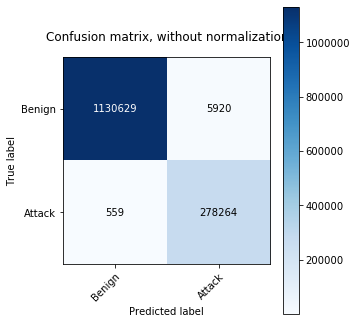

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,3,18,0.166667
Bot,11,983,0.011190
Brute Force -XSS,3,326,0.009202
Benign,5920,1136549,0.005209
DoS attacks-SlowHTTPTest,10,2749,0.003638
DoS attacks-Hulk,402,115537,0.003479
DoS attacks-Slowloris,9,2898,0.003106
SSH-Bruteforce,8,2949,0.002713
DDOS LOIT,98,64014,0.001531
DoS attacks-GoldenEye,6,5147,0.001166


In [35]:
pred_test_gb = clf_gb.predict(X_test)
print_binary_performance(y_test, y_test.label_is_attack.values, pred_test_gb)